In [107]:
# Pour que les changements dans les modules importés (bandits.py) soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import numpy as np
import matplotlib.pyplot as plt

In [109]:
# Changement des paramètres d'affichage par défaut
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 10
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.markersize'] = 15
mpl.rcParams['axes.grid'] = True
# mpl.rcParams.find_all('')

In [110]:
try:
    # Pour utiliser la correction (prof)
    import bandits_correction as bandits
    import exp_correction
    print('Correction importée')
except:
    # Pour utiliser le code fourni à compléter (étudiants)
    import bandits

In [111]:
# Création d'un problème avec 4 bras
bandits_pb = bandits.BernoulliMultiArmedBandits(means = [0.1, 0.85, 0.7, 0.849])
print(bandits_pb)

4-arms bandit problem with Bernoulli distributions


# Les algorithmes de bandits: la classe abstraite `BanditAlgorithm`
Dans `bandits.py`, on fournit une classe abstraite `BanditAlgorithm` générique pour les algorithmes de bandits:
* la méthode abstraite `get_action()` renvoie l'action choisie
* la méthode `fit_step(a, r)` prend en argument une action `a` et une récompense `r` obtenue suite à cette action pour apprendre à partir de cet exemple, par exemple en mettant à jour les estimations des valeurs des bras.  Plusieurs sous-classes sont proposées pour les différentes stratégies de résolution.

La plupart des algorithmes doivent mettre à jour le nombre de tirages $N(a)$ de chaque bras $a$ et sa récompense moyenne $Q(a)$: ces valeurs sont stockées sous forme de tableaux numpy dans les attributs `_value_estimates` et `_n_estimates`, respectivement.

# Exploration pure: stratégie aléatoire

On utilise ici la classe `RandomBanditAlgorithm` qui implémente un algorithme de bandit qui choisit une action totalement aléatoirement, sans rien apprendre.



**À faire sur papier.** Calculez le gain moyen de ce joueur en fonction des vraies valeurs des bras.

Le code ci-dessous est une simulation classique de l'interaction entre un algorithme de bandit et son environnement: choix du bras, récompense, entrainement online.

In [112]:
# Création de l'algo
rand_algo = bandits.RandomBanditAlgorithm(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, sur 15 itérations
for i in range(15):
    i_arm = rand_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    rand_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 1 -> récompense False
Bras 1 -> récompense False
Bras 3 -> récompense False
Bras 0 -> récompense False
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 3 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 0 -> récompense False
Bras 3 -> récompense True
Bras 0 -> récompense False


In [113]:
# On cherche à tracer le regret sur un grand nombre d'itérations
n_draws = 10**4  # On pourra augmenter ce nombre à 10**5 une fois que le code fonctionne bien pour aller plus loin dans les itérations

# Simulation
rand_algo = bandits.RandomBanditAlgorithm(n_arms=bandits_pb.n_arms)
rewards_rand = np.empty(n_draws)
selected_arms_rand = np.empty(n_draws)
for i in range(n_draws):
    i_arm = rand_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    rand_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_rand[i] = r
    selected_arms_rand[i] = i_arm
# Calcul du regret sur une simu
r_max = np.max(bandits_pb._true_values)  # Gain moyen du bras optimal
cum_reward_rand = np.cumsum(rewards_rand)  # Récompenses cumulées
regret_rand = np.arange(1, n_draws+1) * r_max - cum_reward_rand

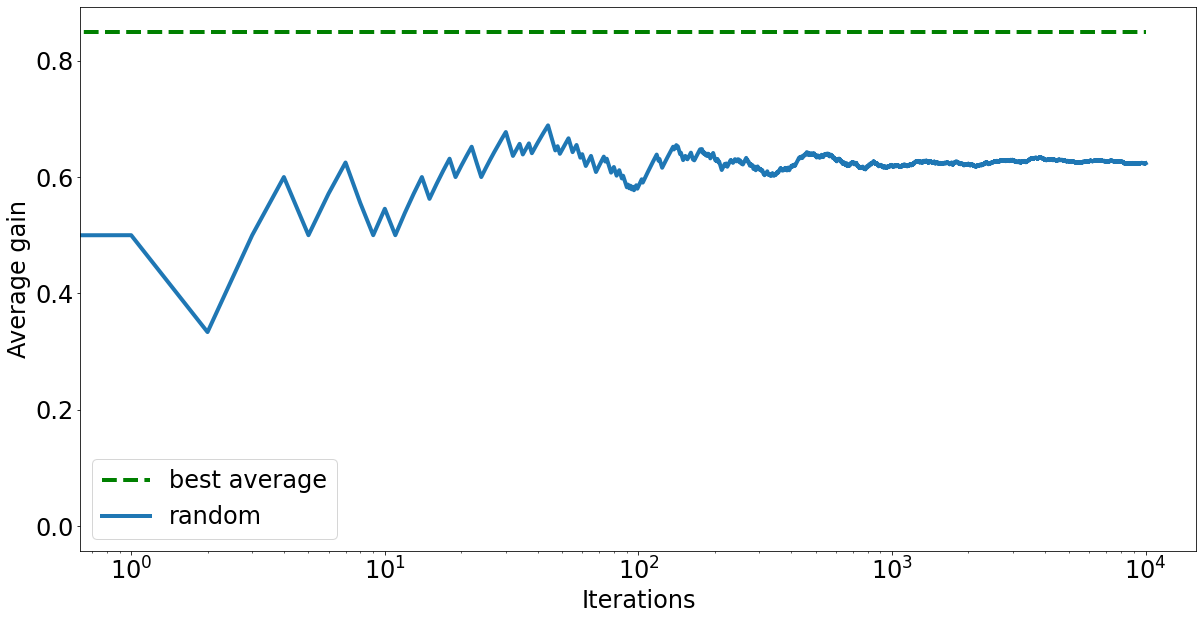

In [114]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.grid()
plt.legend()

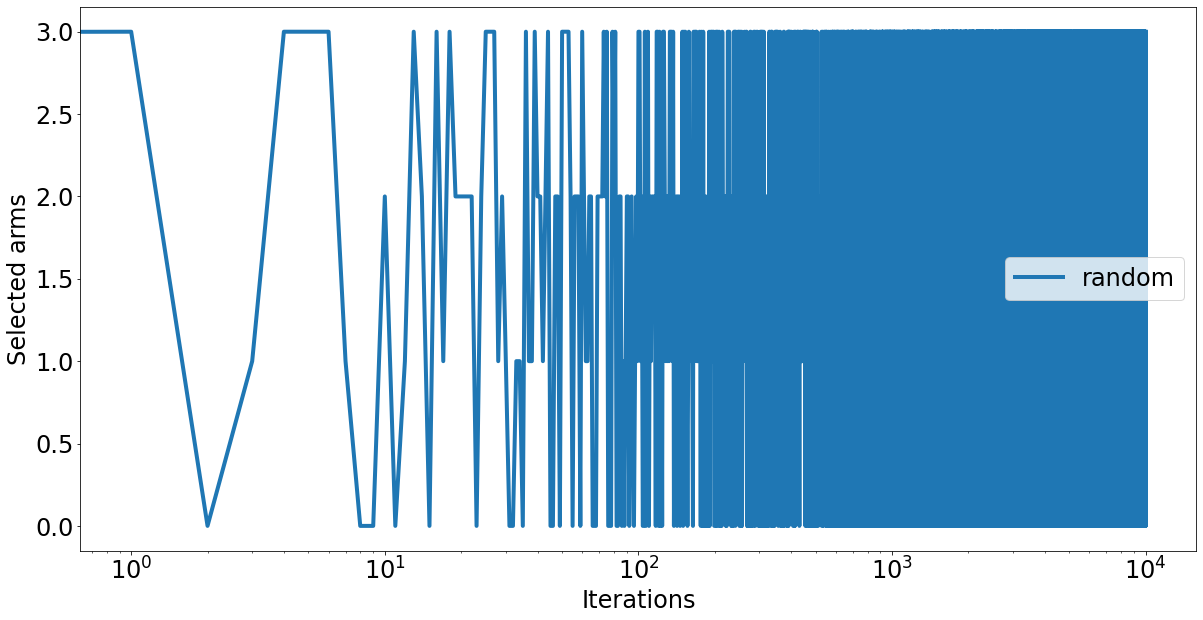

In [115]:
# Les bras sélectionnés
plt.semilogx(selected_arms_rand, label='random')
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
plt.grid()

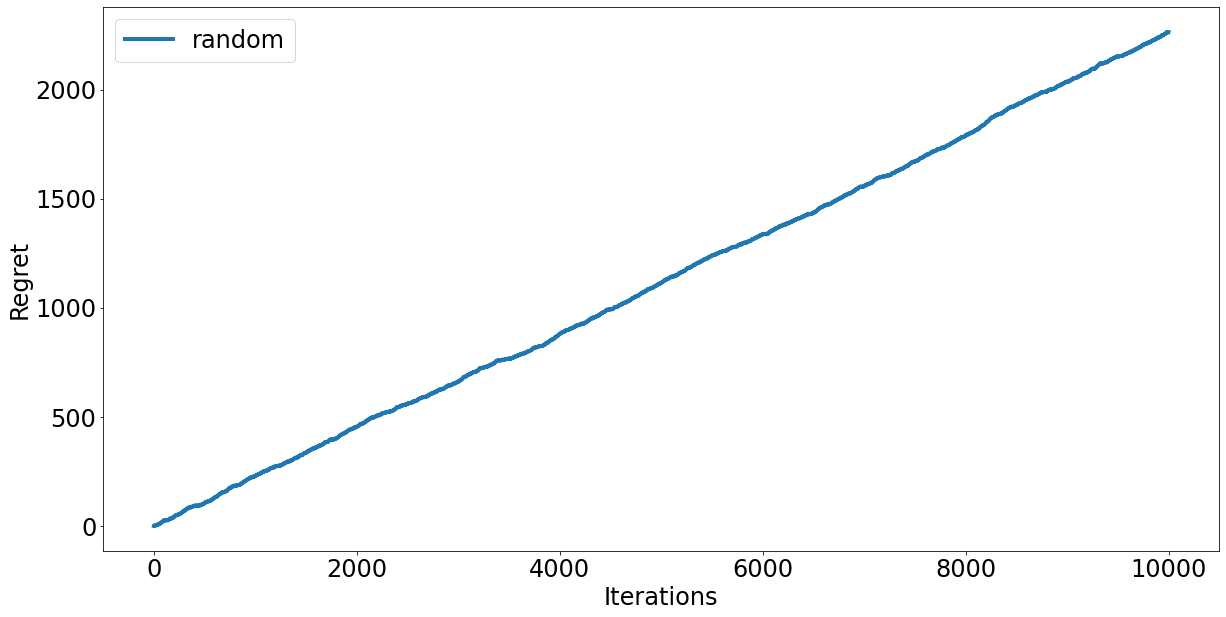

In [116]:
# Le regret sur une simu
plt.plot(regret_rand, label='random')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()

# Exploitation pure: stratégie greedy

**Question à chercher sur papier.** On cherche à mettre à jour les moyennes des gains de chaque bras de façon online. Pour tout $n>0$, on note $\mu_n=\frac{1}{n}\sum_{i=1}^{n} x_i$ la moyenne de $n$ valeurs $x_i$, avec $\mu_0=0$. Montrer mathématiquement que pour tout $n>1$, on a $\mu_n = \mu_{n-1} + \frac{1}{n} \left (x_n - \mu_{n-1}\right )$.

**À faire.** En utilisant la formule précédentes, complétez la méthode `fit_step` de la classe `GreedyBanditAlgorithm` puis implémentez sa méthode `get_action`.

In [117]:
# Création de l'algo
greedy_algo = bandits.GreedyBanditAlgorithm(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 0 -> récompense True
Bras 1 -> récompense False
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 2 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense True


In [118]:
# Une simulation sur un grand nombre d'itérations
np.random.seed(3)
greedy_algo = bandits.GreedyBanditAlgorithm(n_arms=bandits_pb.n_arms)
rewards_greedy = np.empty(n_draws)
selected_arms_greedy = np.empty(n_draws)
for i in range(n_draws):
    i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_greedy[i] = r
    selected_arms_greedy[i] = i_arm
cum_reward_greedy = np.cumsum(rewards_greedy)  # Récompenses cumulées


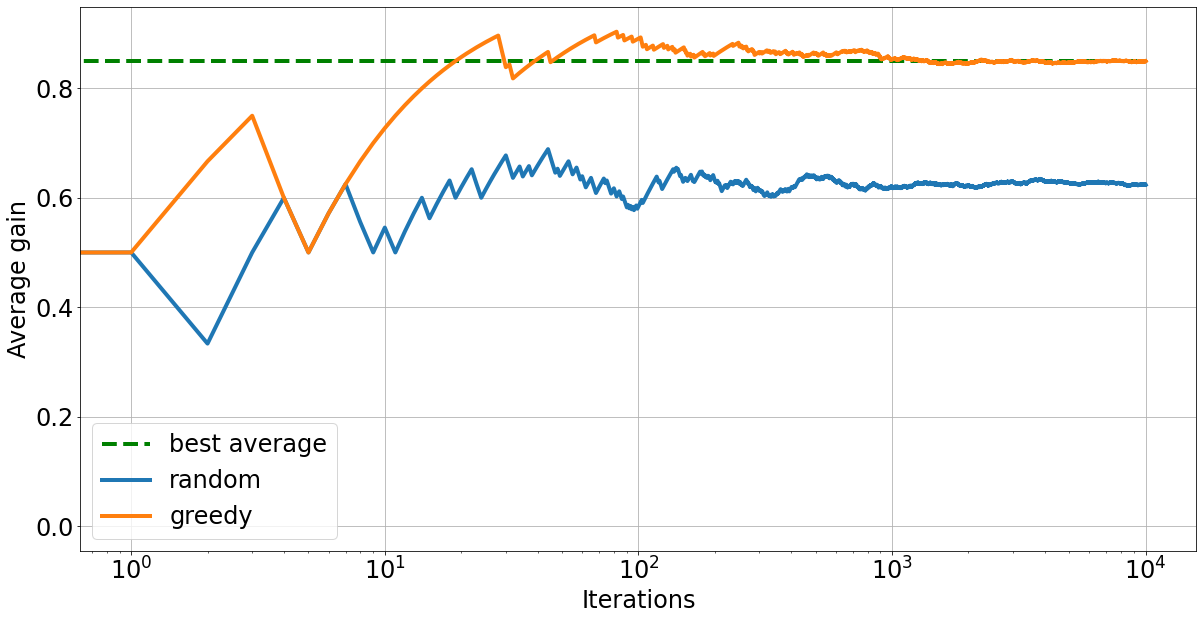

In [119]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

[0.1   0.85  0.7   0.849]
[0.         0.         0.         0.84970983]
[   1    2    2 9995]


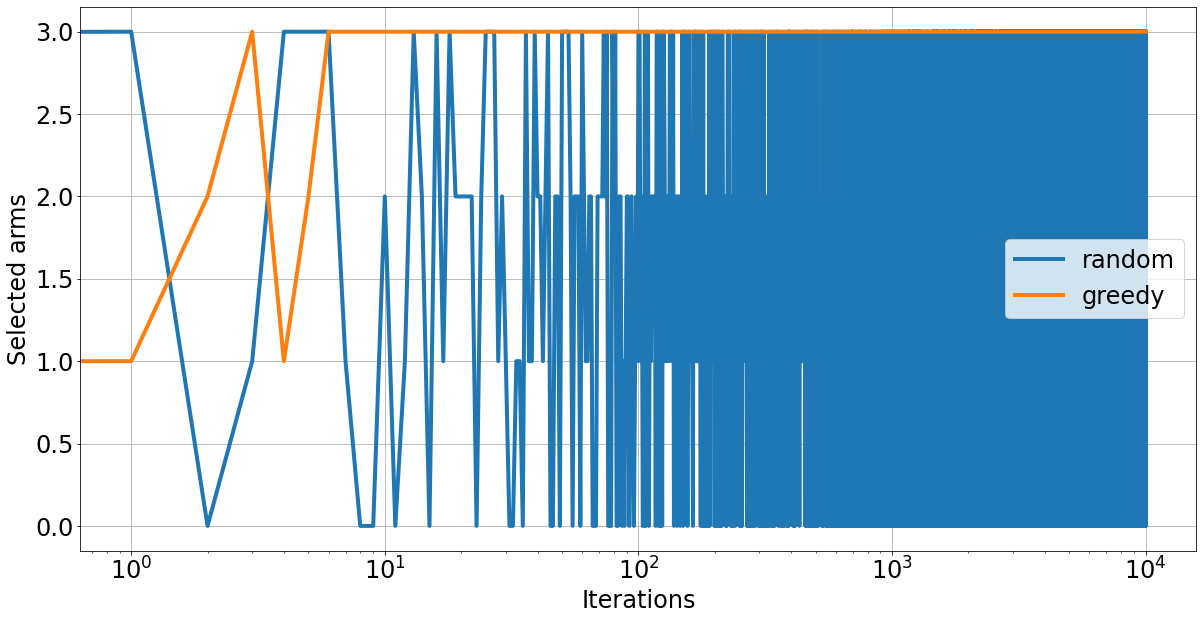

In [120]:
plt.semilogx(selected_arms_rand, label='random')
plt.semilogx(selected_arms_greedy, label='greedy')
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
print(bandits_pb._means)
print(greedy_algo._value_estimates)
print(greedy_algo._n_estimates)

**À faire.** La stratégie greedy peut rester piégée dans un mauvais choix. Répétez l'expérience précédente un grand nombre de fois (50) en réinitialisant l'algorithme à chaque fois; calculer ensuite un regret empirique en faisant des moyennes par rapport à toutes les initialisations de l'algorithme et tracez-le.

In [122]:
# À compléter
regret_greedy=np.zeros((50,n_draws))
for _ in range(50):
    np.random.seed(3)
    greedy_algo = bandits.GreedyBanditAlgorithm(n_arms=bandits_pb.n_arms)
    rewards_greedy = np.empty(n_draws)
    selected_arms_greedy = np.empty(n_draws)
    for i in range(n_draws):
        i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
        r = bandits_pb.step(i_arm)  # Récompense obtenue
        greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
        rewards_greedy[i] = r
        selected_arms_greedy[i] = i_arm
    cum_reward_greedy = np.cumsum(rewards_greedy)  # Récompenses cumulées
    r_max = np.max(bandits_pb._true_values)
    regret_greedy[_] = np.arange(1, n_draws+1) * r_max - cum_reward_greedy

In [123]:
mean_regret_greedy =np.mean(regret_greedy,axis=0)

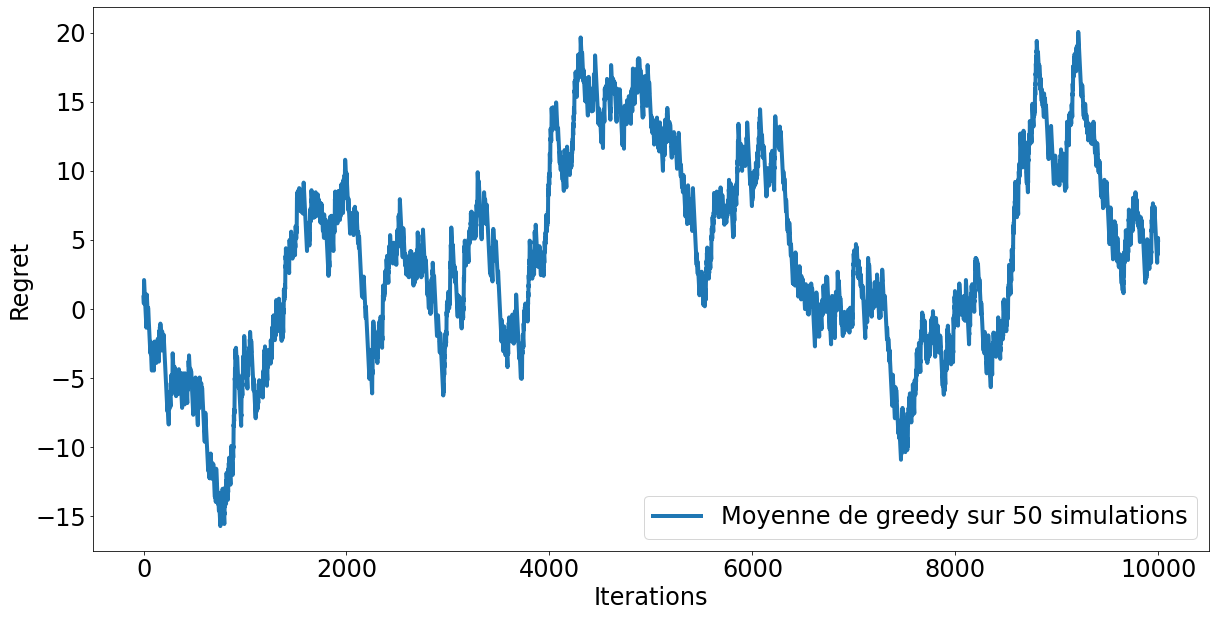

In [124]:
# Le regret sur une simu
plt.plot(mean_regret_greedy, label='Moyenne de greedy sur 50 simulations')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()

In [125]:
# Correction
try:
    my_vars = dict()
    my_vars['bandits_pb'] = bandits_pb
    my_vars['n_draws'] = n_draws
    my_vars['regret_rand'] = regret_rand
    my_vars['cum_reward_rand'] = cum_reward_rand
    exp_correction.exp_greedy(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie $\epsilon$-greedy
**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `EpsilonGreedyBanditAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie $\epsilon$-greedy et tracez les résultats de toutes les stratégies en les superposant. Vous pourrez fixer $\epsilon=0.01$ dans un premier temps. Tester ensuite plusieurs valeurs de $\epsilon$ telles que $\epsilon=0.1$ et $\epsilon=0$, superposez les courbes et commentez-les.

In [126]:
# À compléter


# Création de l'algo
greedy_algo = bandits.EpsilonGreedyBanditAlgorithm(n_arms=bandits_pb.n_arms,epsilon = 0.01)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))



Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense True
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False
Bras 0 -> récompense False


In [127]:
# Une simulation sur un grand nombre d'itérations
np.random.seed(3)
epsilon_greedy_algo = bandits.EpsilonGreedyBanditAlgorithm(n_arms=bandits_pb.n_arms,epsilon = 0.01)
rewards_epsilon_greedy = np.empty(n_draws)
selected_arms_epsilon_greedy = np.empty(n_draws)
for i in range(n_draws):
    i_arm = epsilon_greedy_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    epsilon_greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_epsilon_greedy[i] = r
    selected_arms_epsilon_greedy[i] = i_arm
cum_reward_epsilon_greedy = np.cumsum(rewards_epsilon_greedy)  # Récompenses cumulées

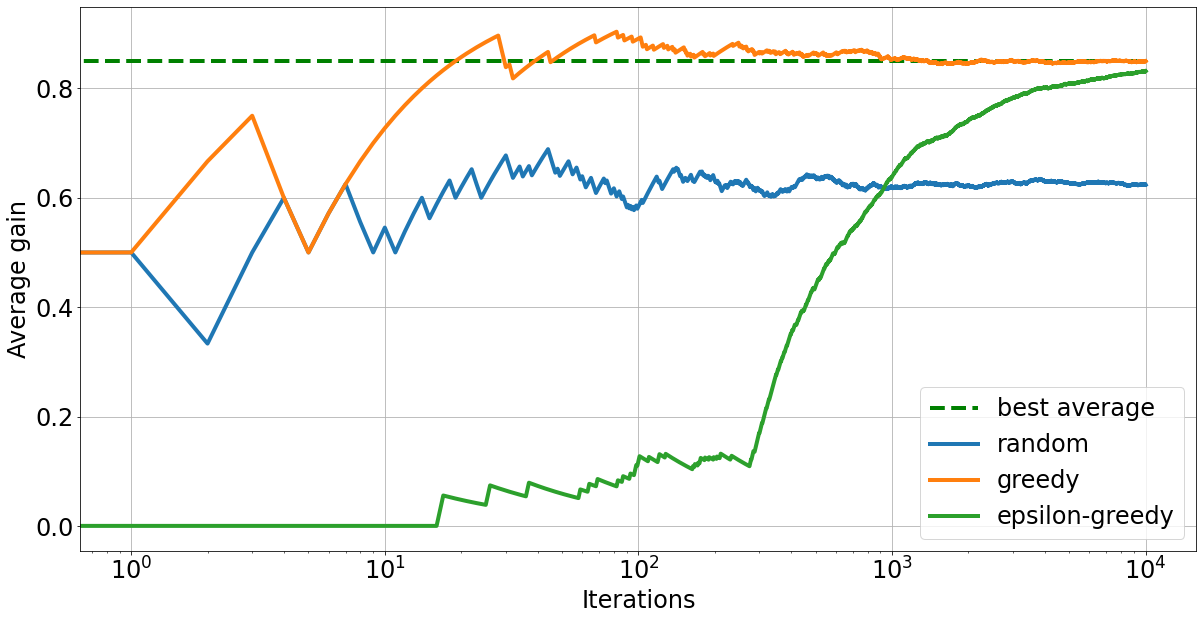

In [128]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.semilogx(cum_reward_epsilon_greedy / np.arange(1, n_draws+1), label='epsilon-greedy')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

[0.1   0.85  0.7   0.849]
[0.10689655 0.85356475 0.7027027  0.84313725]
[ 290 9622   37   51]


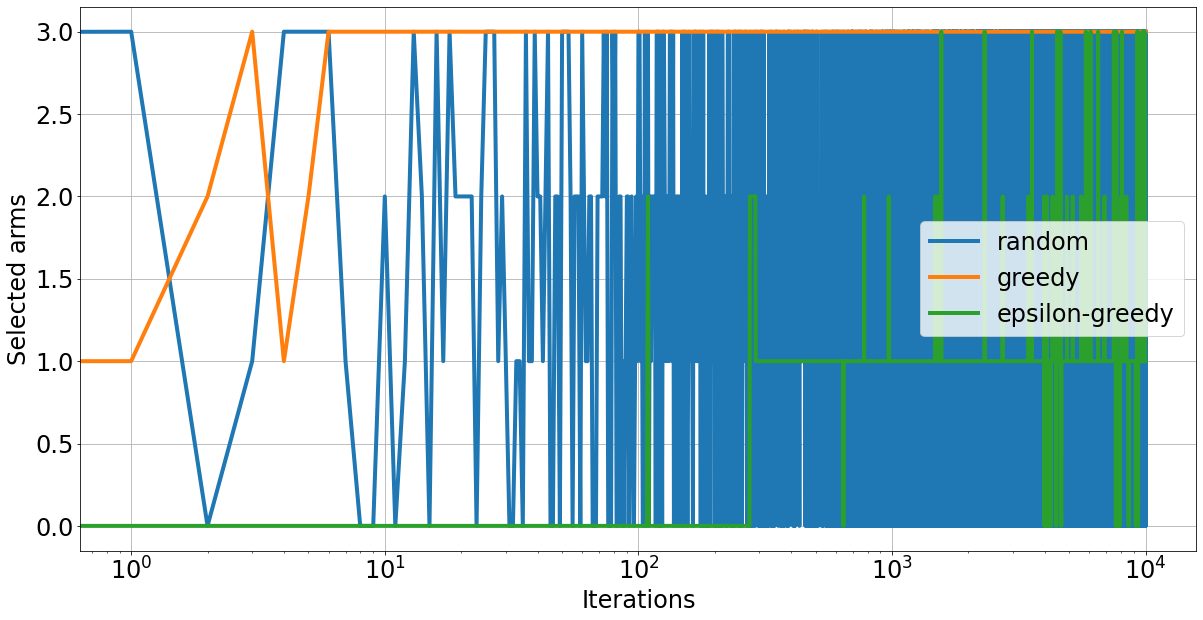

In [129]:
plt.semilogx(selected_arms_rand, label='random')
plt.semilogx(selected_arms_greedy, label='greedy')
plt.semilogx(selected_arms_epsilon_greedy, label='epsilon-greedy')
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
print(bandits_pb._means)
print(epsilon_greedy_algo._value_estimates)
print(epsilon_greedy_algo._n_estimates)

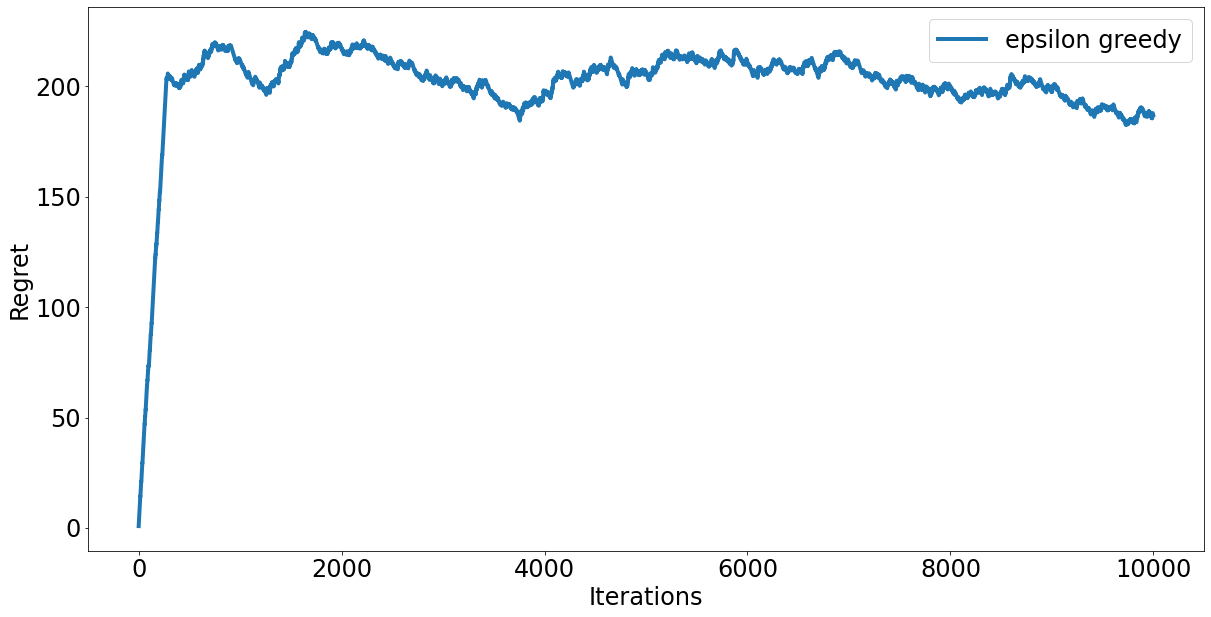

In [130]:
regret_epsilon_greedy = np.arange(1, n_draws+1) * r_max - cum_reward_epsilon_greedy

# Le regret sur une simu
plt.plot(regret_epsilon_greedy, label='epsilon greedy')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()

In [131]:
# Une simulation sur un grand nombre d'itérations avec epsilon 0.1
np.random.seed(3)
epsilon_greedy_algo_v1 = bandits.EpsilonGreedyBanditAlgorithm(n_arms=bandits_pb.n_arms,epsilon = 0.1)
rewards_epsilon_greedy_v1 = np.empty(n_draws)
selected_arms_epsilon_greedy_v1 = np.empty(n_draws)
for i in range(n_draws):
    i_arm = epsilon_greedy_algo_v1.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    epsilon_greedy_algo_v1.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_epsilon_greedy_v1[i] = r
    selected_arms_epsilon_greedy_v1[i] = i_arm
cum_reward_epsilon_greedy_v1 = np.cumsum(rewards_epsilon_greedy_v1)  # Récompenses cumulées

In [132]:
# Une simulation sur un grand nombre d'itérations avec epsilon 0
np.random.seed(3)
epsilon_greedy_algo_v2 = bandits.EpsilonGreedyBanditAlgorithm(n_arms=bandits_pb.n_arms,epsilon = 0)
rewards_epsilon_greedy_v2 = np.empty(n_draws)
selected_arms_epsilon_greedy_v2 = np.empty(n_draws)
for i in range(n_draws):
    i_arm = epsilon_greedy_algo_v2.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    epsilon_greedy_algo_v2.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_epsilon_greedy_v2[i] = r
    selected_arms_epsilon_greedy_v2[i] = i_arm
cum_reward_epsilon_greedy_v2 = np.cumsum(rewards_epsilon_greedy_v2)  # Récompenses cumulées

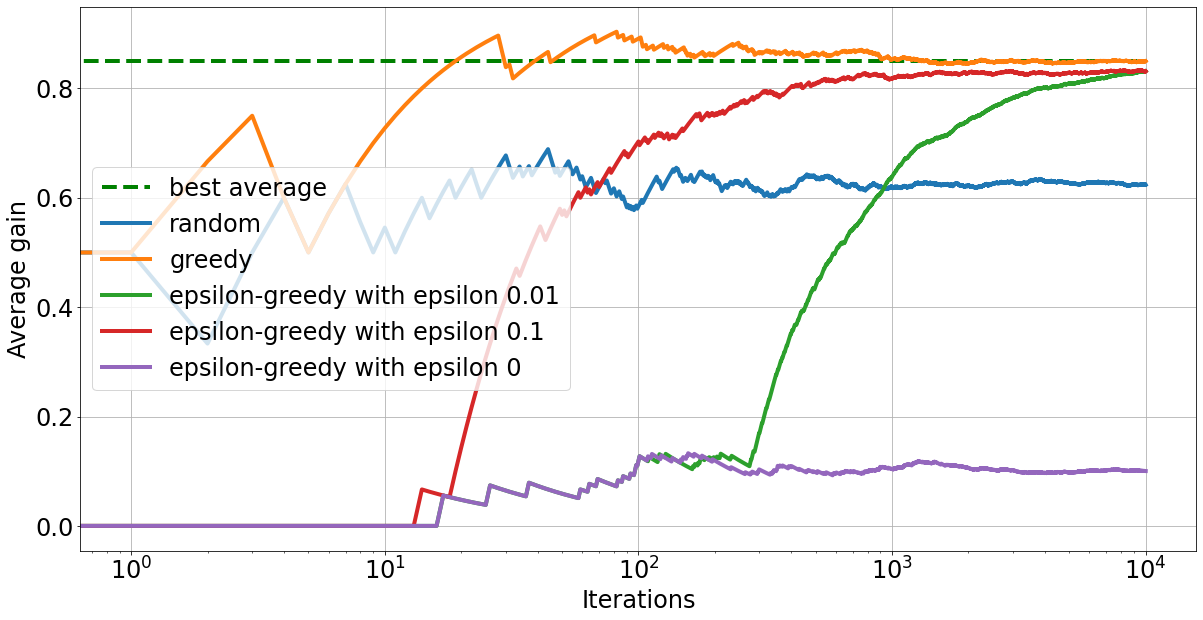

In [133]:
# On trace le gain moyen en fonction des itérations pour les 3 algorithmes
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.semilogx(cum_reward_epsilon_greedy / np.arange(1, n_draws+1), label='epsilon-greedy with epsilon ' + str(0.01))
plt.semilogx(cum_reward_epsilon_greedy_v1 / np.arange(1, n_draws+1), label='epsilon-greedy with epsilon ' + str(0.1))
plt.semilogx(cum_reward_epsilon_greedy_v2 / np.arange(1, n_draws+1), label='epsilon-greedy with epsilon ' + str(0))
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

######## Algo avec epsilon 0,01 ########
[0.1   0.85  0.7   0.849]
[0.10689655 0.85356475 0.7027027  0.84313725]
[ 290 9622   37   51]
########################
######## Algo avec epsilon 0,1 ########
[0.1   0.85  0.7   0.849]
[0.1372549  0.85347015 0.69603524 0.83736264]
[ 255 9063  227  455]
########################
######## Algo avec epsilon 0 ########
[0.1   0.85  0.7   0.849]
[0.1003 0.     0.     0.    ]
[10000     0     0     0]


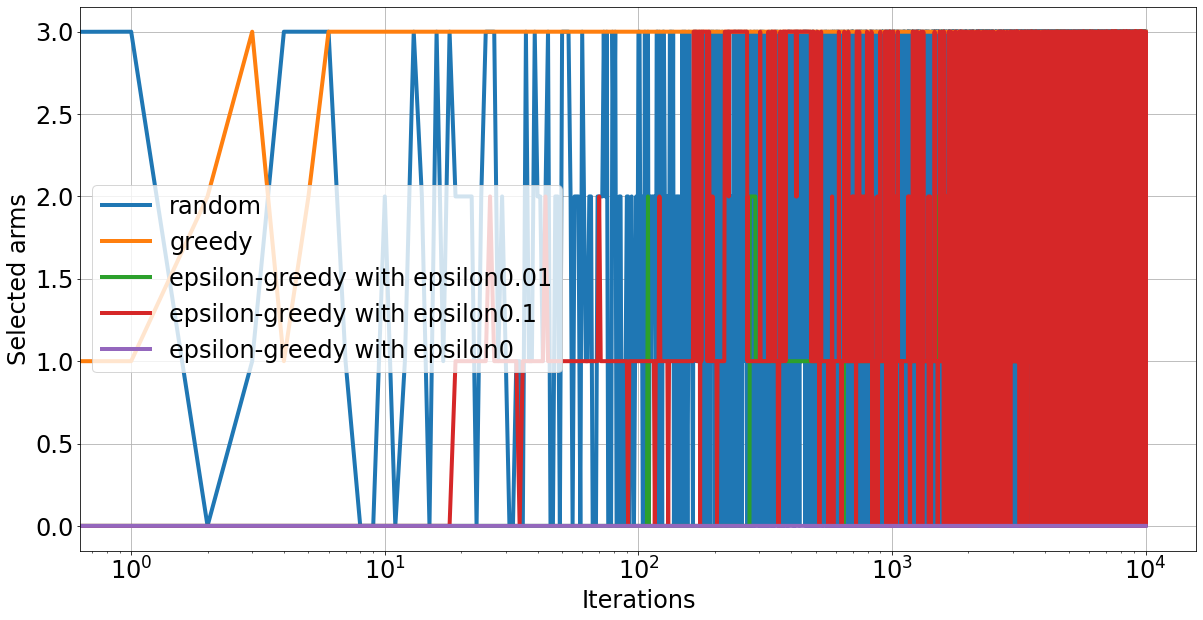

In [134]:
plt.semilogx(selected_arms_rand, label='random')
plt.semilogx(selected_arms_greedy, label='greedy')
plt.semilogx(selected_arms_epsilon_greedy, label='epsilon-greedy with epsilon' + str(0.01))
plt.semilogx(selected_arms_epsilon_greedy_v1, label='epsilon-greedy with epsilon' + str(0.1))
plt.semilogx(selected_arms_epsilon_greedy_v2, label='epsilon-greedy with epsilon' + str(0))
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()

print("######## Algo avec epsilon 0,01 ########")
print(bandits_pb._means)
print(epsilon_greedy_algo._value_estimates)
print(epsilon_greedy_algo._n_estimates)
print("########################")
print("######## Algo avec epsilon 0,1 ########")
print(bandits_pb._means)
print(epsilon_greedy_algo_v1._value_estimates)
print(epsilon_greedy_algo_v1._n_estimates)
print("########################")
print("######## Algo avec epsilon 0 ########")
print(bandits_pb._means)
print(epsilon_greedy_algo_v2._value_estimates)
print(epsilon_greedy_algo_v2._n_estimates)

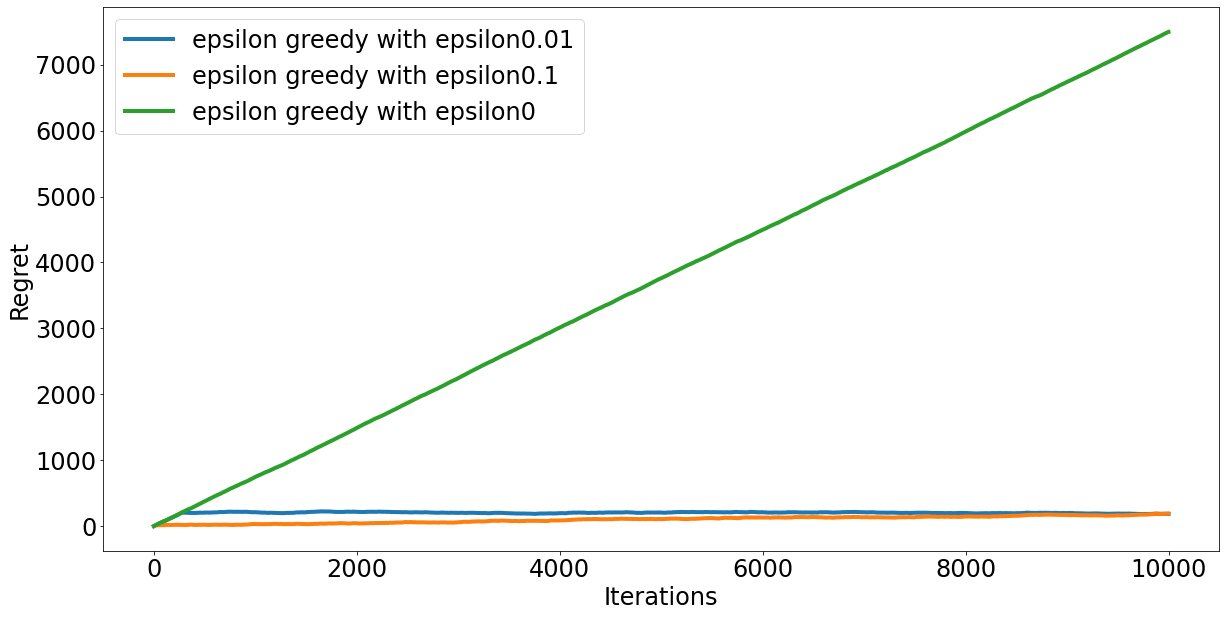

In [135]:
regret_epsilon_greedy = np.arange(1, n_draws+1) * r_max - cum_reward_epsilon_greedy
regret_epsilon_greedy_v1 = np.arange(1, n_draws+1) * r_max - cum_reward_epsilon_greedy_v1
regret_epsilon_greedy_v2 = np.arange(1, n_draws+1) * r_max - cum_reward_epsilon_greedy_v2

# Le regret sur une simu
plt.plot(regret_epsilon_greedy, label='epsilon greedy with epsilon' + str(0.01))
plt.plot(regret_epsilon_greedy_v1, label='epsilon greedy with epsilon' + str(0.1))
plt.plot(regret_epsilon_greedy_v2, label='epsilon greedy with epsilon' + str(0))
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()

L'algo Espilon-Greedy avec epsilon de valeur 0 est le meme que l'algo greedy tout court. 

En augement la valeur de epsilon, l'algorithme Espilon-Greedy parcoure de plus en plus des bras qui ne sont pas l'optimal ce qui resulte a une somme cumulative de recompemse moins importante et donc a un regret plus important.

In [45]:
# Correction
try:
    from exp_correction import exp_epsgreedy_1
    exp_epsgreedy_1(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


In [46]:
# Correction
try:
    exp_correction.exp_epsgreedy_50(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie UCB

**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `UcbBanditAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie UCB et tracez les résultats de toutes les stratégies en les superposant.

# Exercice1 

In [49]:

# Création de l'algo
UCB_algo = bandits.UcbBanditAlgorithm(n_arms=bandits_pb.n_arms,c=1,t=1/0.05)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = UCB_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    UCB_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 0 -> récompense False
Bras 1 -> récompense False
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 2 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True


In [50]:
# Une simulation sur un grand nombre d'itérations pour l'algorithme UCB
np.random.seed(3)
UCB_algo = bandits.UcbBanditAlgorithm(n_arms=bandits_pb.n_arms,c=1,t=1/0.05)
rewards_Ucb = np.empty(n_draws)
selected_arms_Ucb= np.empty(n_draws)
upper_bound_per_arm = np.zeros((bandits_pb.n_arms,n_draws)) # Upper Confidence Bound per arm at each iteration
lower_bound_per_arm = np.zeros((bandits_pb.n_arms,n_draws)) # Lower Confidence Bound per arm at each iteration
average_reward_per_arm = np.zeros((bandits_pb.n_arms,n_draws)) # average reward per arm at each iteration
for i in range(n_draws):
    i_arm = UCB_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    UCB_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_Ucb[i] = r
    selected_arms_Ucb[i] = i_arm
    upper_bounds , lower_bounds = UCB_algo.get_upper_confidence_bound()
    for j in range(bandits_pb.n_arms):
        upper_bound_per_arm[j][i] , lower_bound_per_arm[j][i] = upper_bounds[j] , lower_bounds[j]
        average_reward_per_arm[j][i] = UCB_algo._value_estimates[j]                          
                
cum_reward_Ucb = np.cumsum(rewards_Ucb)  # Récompenses cumulées

/home/phillyflingo/Desktop/ECM/M2 IAAA/temps2/AR/seance1/bandits.py:371: RuntimeWarning: divide by zero encountered in double_scalars
  class ThompsonSamplingAlgorithm(BanditAlgorithm):
/home/phillyflingo/Desktop/ECM/M2 IAAA/temps2/AR/seance1/bandits.py:372: RuntimeWarning: divide by zero encountered in double_scalars
  """


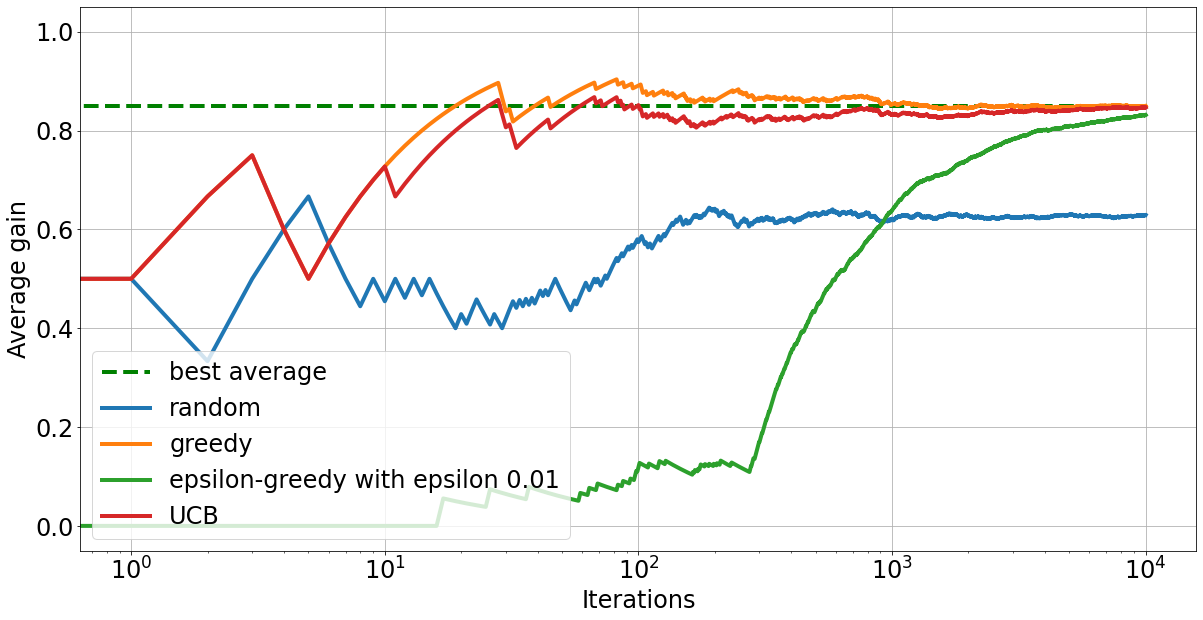

In [51]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.semilogx(cum_reward_epsilon_greedy / np.arange(1, n_draws+1), label='epsilon-greedy with epsilon {}'.format(0.01))
plt.semilogx(cum_reward_Ucb / np.arange(1, n_draws+1), label='UCB')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

Les valeurs des differents bras [0.1   0.85  0.7   0.849]
Estimation des valeurs des differents bras [0.16666667 0.84522003 0.75555556 0.85131647]
Nombre de fois où chaque bras a été choisi [   7 3955  226 5812]


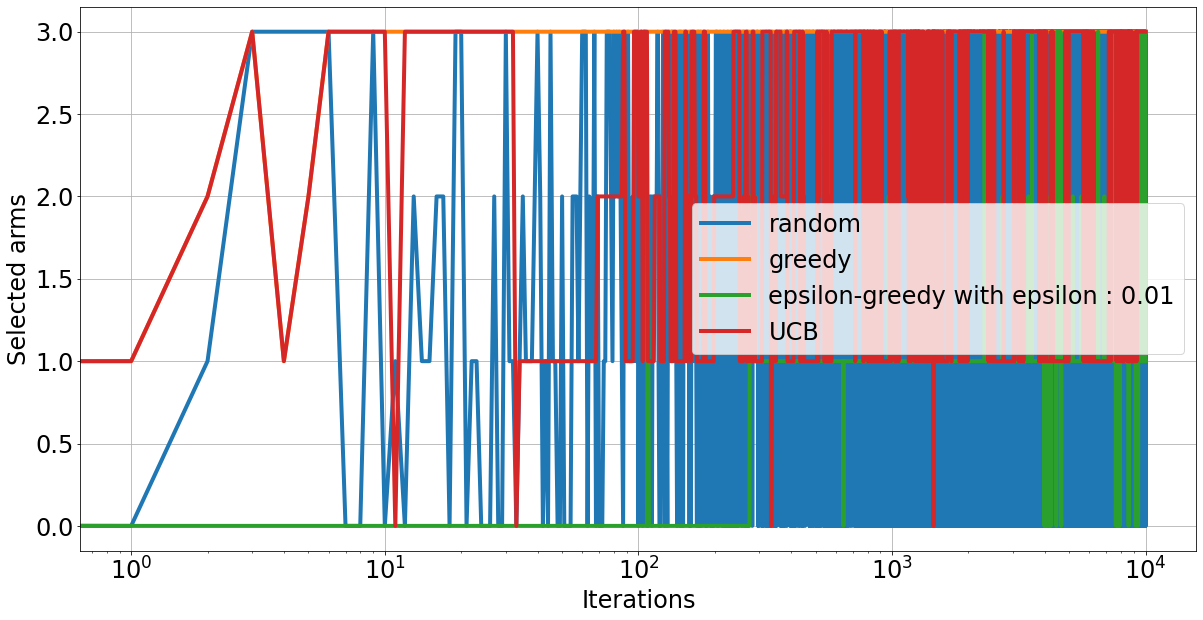

In [52]:
plt.semilogx(selected_arms_rand, label='random')
plt.semilogx(selected_arms_greedy, label='greedy')
plt.semilogx(selected_arms_epsilon_greedy, label='epsilon-greedy with epsilon : {}'.format(0.01))
plt.semilogx(selected_arms_Ucb, label='UCB')
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
print("Les valeurs des differents bras {}".format(bandits_pb._means))
print('Estimation des valeurs des differents bras {}'.format(UCB_algo._value_estimates))
print('Nombre de fois où chaque bras a été choisi {}'.format(UCB_algo._n_estimates))

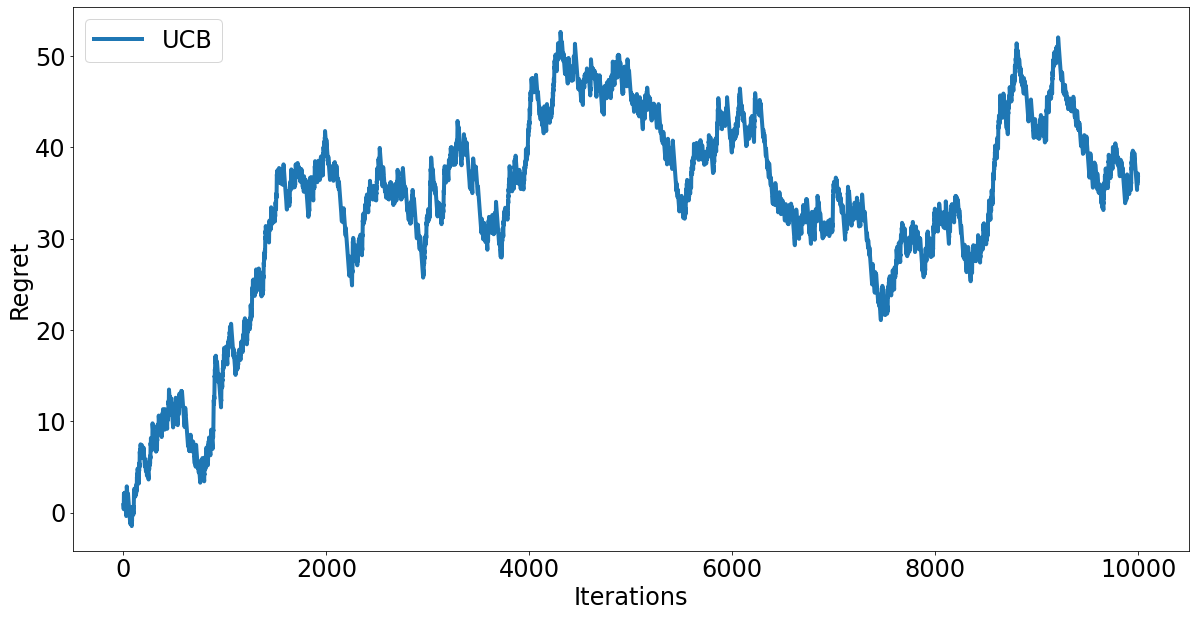

In [53]:
regret_Ucb = np.arange(1, n_draws+1) * r_max - cum_reward_Ucb

# Le regret sur une simu
plt.plot(regret_Ucb, label='UCB')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()

In [36]:
# Correction
try:
    exp_correction.exp_ucb(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


**À faire.** Pour UCB, tracez, en fonction des itérations, la moyenne et la borne supérieure de chaque bras en superposant les courbes sur un unique graphique (dans le même esprit que dans le cours). Analysez la figure obtenue.

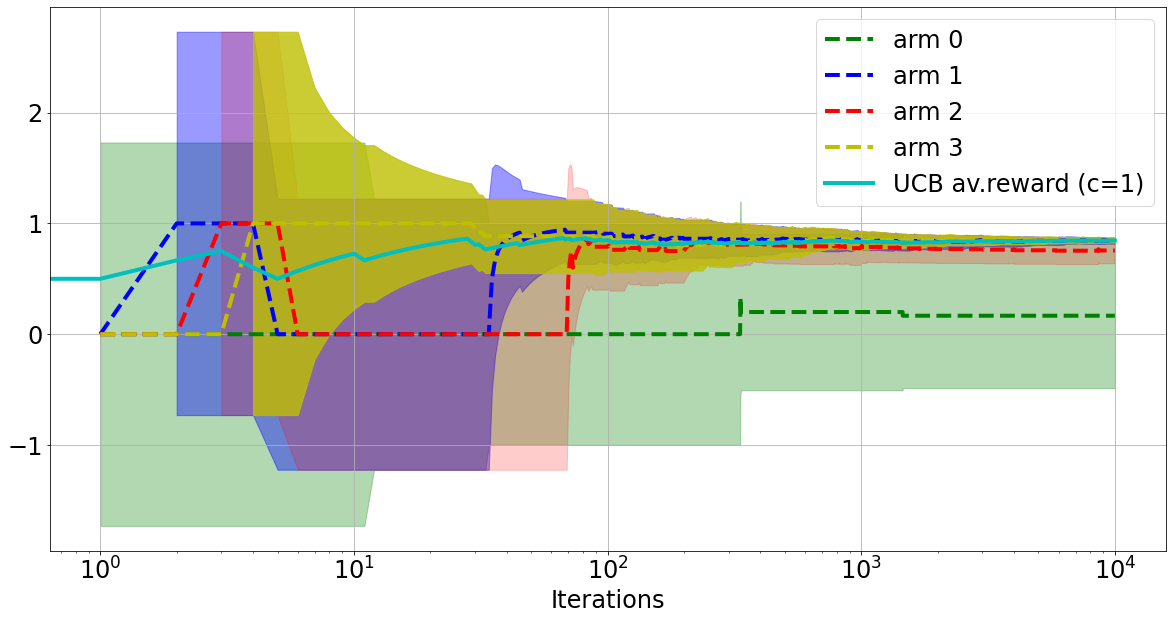

In [54]:
# À compléter
# upper_bound, lower_bound = UCB_algo.get_upper_confidence_bound()



plt.plot(np.arange(1,n_draws+1),average_reward_per_arm[0], '--g', label='arm 0')
plt.plot(np.arange(1,n_draws+1),average_reward_per_arm[1], '--b', label='arm 1')
plt.plot(np.arange(1,n_draws+1),average_reward_per_arm[2], '--r', label='arm 2')
plt.plot(np.arange(1,n_draws+1),average_reward_per_arm[3], '--y', label='arm 3')


plt.fill_between(np.arange(1,n_draws+1), upper_bound_per_arm[0],lower_bound_per_arm[0], color='g',alpha=0.3)
plt.fill_between(np.arange(1,n_draws+1), upper_bound_per_arm[1],lower_bound_per_arm[1], color='b',alpha=0.4)
plt.fill_between(np.arange(1,n_draws+1), upper_bound_per_arm[2],lower_bound_per_arm[2], color='r',alpha=0.2)
plt.fill_between(np.arange(1,n_draws+1), upper_bound_per_arm[3],lower_bound_per_arm[3], color='y',alpha=0.8)


plt.semilogx(cum_reward_Ucb / np.arange(1, n_draws+1),color='c', label='UCB av.reward (c=1)')

plt.xscale('log')


plt.xlabel('Iterations')
plt.legend()


Nous observons que le bras 3 est celui qui a la borne de confiance superieure maximale sur un grand nombre d'iterations donc c'est ce bras qui va etre choisi la plupart des fois par l'algorithme UCB et qui contribuera le plus au gain moyen de l'algorithme.

In [40]:
# Correction
try:
    exp_correction.exp_ucb_tracking(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie Thomson Sampling
 **À faire (séance 2).** Complétez les méthodes `fit_step` et `get_action` de la classe `ThompsonSamplingAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie Thomson Sampling et tracez les résultats de toutes les stratégies en les superposant.

# Exercice 2

In [55]:
# Création d'un problème avec 5 bras avec des parametres tires au hasard
bandits_pb = bandits.BernoulliMultiArmedBandits(means = [np.random.random(1)[0], np.random.random(1)[0], np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]])
print(bandits_pb)

5-arms bandit problem with Bernoulli distributions


In [57]:
# Une simulation sur un grand nombre d'itérations pour l'algorithme Thompson Sampling
np.random.seed(3)
n_draws = 10000

thomson_algo = bandits.ThompsonSamplingAlgorithm(n_arms=bandits_pb.n_arms)

rewards_thomson = np.empty(n_draws)
selected_arms_thomson= np.empty(n_draws)

alpha_per_arm = np.ones((bandits_pb.n_arms,n_draws))
beta_per_arm = np.ones((bandits_pb.n_arms,n_draws))


for i in range(n_draws):
    i_arm = thomson_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    thomson_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_thomson[i] = r
    selected_arms_thomson[i] = i_arm
    for arm in range(bandits_pb.n_arms):
        alpha_per_arm[arm][i] = thomson_algo.alpha[arm]
        beta_per_arm[arm][i] = thomson_algo.beta[arm]
                         
                
cum_reward_thomson = np.cumsum(rewards_thomson)  # Récompenses cumulées

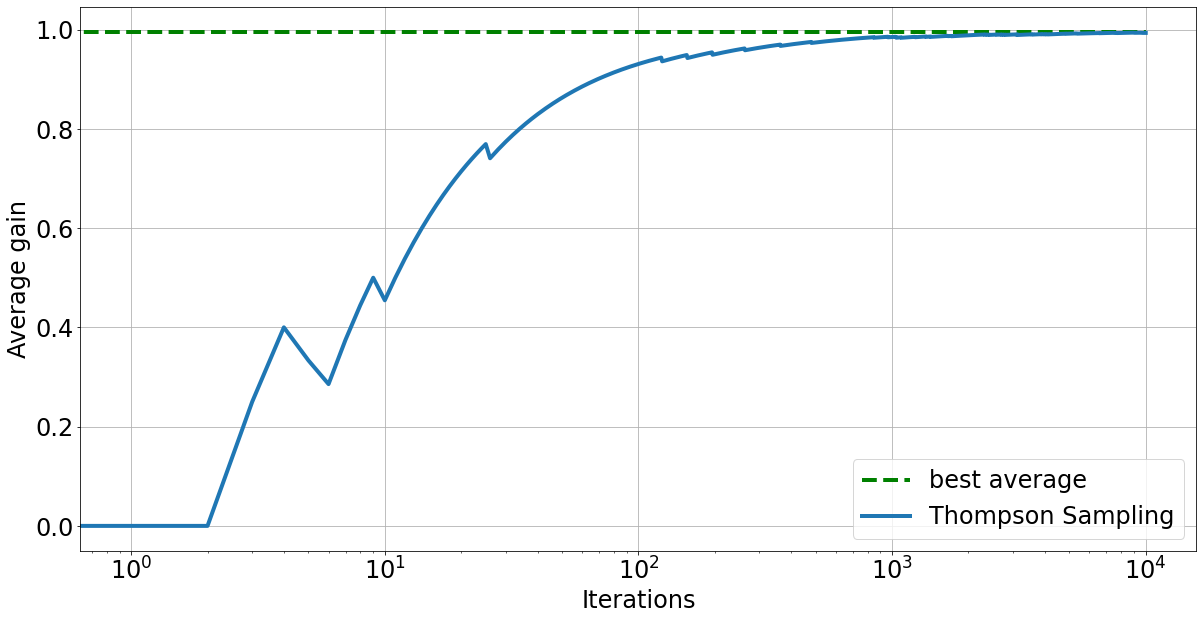

In [58]:
# On trace le gain moyen en fonction des itérations

r_max = np.max(bandits_pb._true_values)

plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_thomson / np.arange(1, n_draws+1), label='Thompson Sampling')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

In [59]:
print("Les valeurs des differents bras {}".format(bandits_pb._means))
print("Estimation des valeurs des differents bras par l'algorithme Thompson Sampling {}".format(thomson_algo._value_estimates))
print('Nombre de fois où chaque bras a été choisi {}'.format(thomson_algo._n_estimates))



Les valeurs des differents bras [0.33053101 0.80262662 0.99568904 0.32074402 0.41767669]
Estimation des valeurs des differents bras par l'algorithme Thompson Sampling [0.         0.90625    0.99427596 0.         0.        ]
Nombre de fois où chaque bras a été choisi [   2   33 9959    3    3]


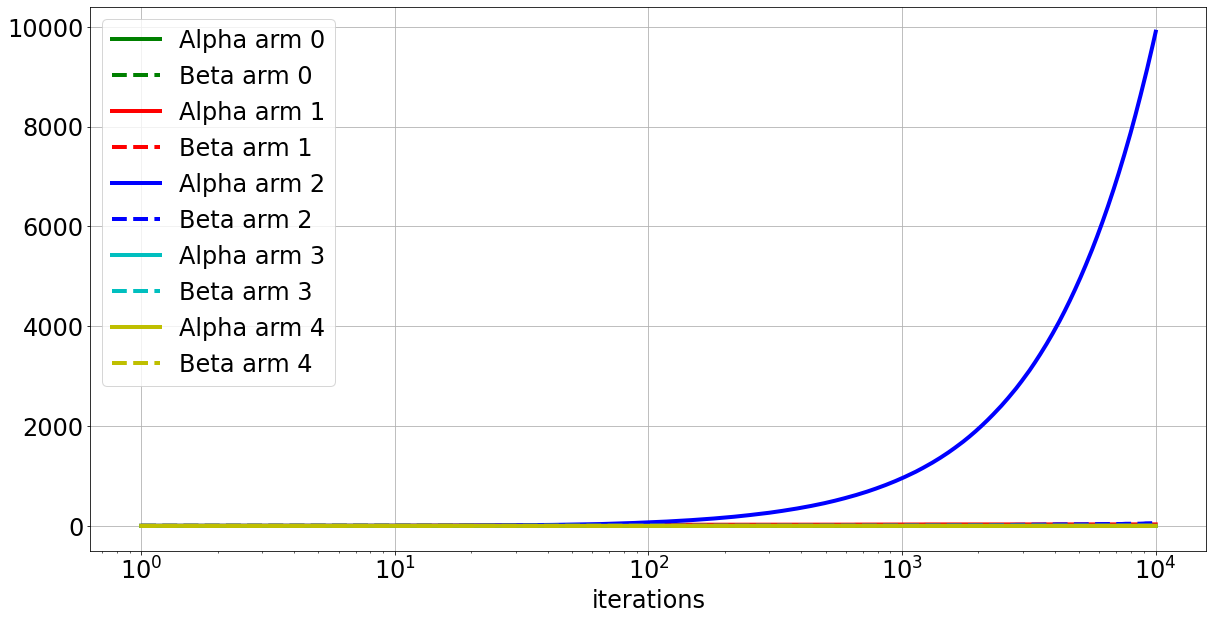

In [60]:
# Les alphas sont tracés en continu et les betas sont tracés en pointillé



plt.semilogx(np.arange(1,n_draws+1),alpha_per_arm[0],'g',label='Alpha arm 0')
plt.semilogx(np.arange(1,n_draws+1),beta_per_arm[0],'--g',label='Beta arm 0')

plt.semilogx(np.arange(1,n_draws+1),alpha_per_arm[1],'r',label='Alpha arm 1')
plt.semilogx(np.arange(1,n_draws+1),beta_per_arm[1],'--r',label='Beta arm 1')

plt.semilogx(np.arange(1,n_draws+1),alpha_per_arm[2],'b',label='Alpha arm 2')
plt.semilogx(np.arange(1,n_draws+1),beta_per_arm[2],'--b',label='Beta arm 2')


plt.semilogx(np.arange(1,n_draws+1),alpha_per_arm[3],'c',label='Alpha arm 3')
plt.semilogx(np.arange(1,n_draws+1),beta_per_arm[3],'--c',label='Beta arm 3')


plt.semilogx(np.arange(1,n_draws+1),alpha_per_arm[4],'y',label='Alpha arm 4')
plt.semilogx(np.arange(1,n_draws+1),beta_per_arm[4],'--y',label='Beta arm 4')




plt.xlabel("iterations")
plt.legend()

Nous remarquons que alpha et beta du bras 1 sont élevés par rapport aux autres bras ce qui est normal puisque c'est le bras qui a été choisi le plus. Nous remarquons aussi que la valeur de alpha du bras 1 est largement superieur au beta du bras 1 . Ceci est dû au fait que la valeur du bras 1 est assez importante et donc la probablité du succès du bras 1 à chaque iteration dont lequel le bras 1 a été choisi est importante.

In [46]:
# Correction
try:
    exp_correction.exp_ts(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


# Exercice 3 

 En utilisant l’environnement BernoulliMultiArmedBandits avec 5 bras , nous comparions les stratégies Thompson Sampling,
UCB (c = 1) et epsilon-greedy en moyennant les résultats sur plusieurs réalisations

In [61]:
# Création d'un problème avec 5 bras avec des parametres tires au hasard
bandits_pb = bandits.BernoulliMultiArmedBandits(means = [np.random.random(1)[0], np.random.random(1)[0], np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]])
print(bandits_pb)
print("Les valeurs de chaque bras {}".format(bandits_pb._true_values))

5-arms bandit problem with Bernoulli distributions
Les valeurs de chaque bras [0.37118232 0.75857499 0.29905916 0.84450191 0.62370143]


In [62]:
# 20 simulation sur un grand nombre d'itérations pour l'algorithme Thompson Sampling
np.random.seed(3)
n_draws = 10000

n_simulations = 20

cum_reward_thomson = np.empty((n_simulations,n_draws))

for simulation in range(n_simulations):
    thomson_algo = bandits.ThompsonSamplingAlgorithm(n_arms=bandits_pb.n_arms)

    rewards_thomson = np.empty((n_simulations,n_draws))
    selected_arms_thomson= np.empty(n_draws)

    alpha_per_arm = np.ones((bandits_pb.n_arms,n_draws))
    beta_per_arm = np.ones((bandits_pb.n_arms,n_draws))


    for i in range(n_draws):
        i_arm = thomson_algo.get_action()  # Choix du bras par l'algo
        r = bandits_pb.step(i_arm)  # Récompense obtenue
        thomson_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
        rewards_thomson[simulation][i] = r
        selected_arms_thomson[i] = i_arm
        for arm in range(bandits_pb.n_arms):
            alpha_per_arm[arm][i] = thomson_algo.alpha[arm]
            beta_per_arm[arm][i] = thomson_algo.beta[arm]


    cum_reward_thomson[simulation] = np.cumsum(rewards_thomson[simulation])  # Récompenses cumulées
    
    
  

On calcule la moyenne des resultats sur 20 realisations

In [63]:
mean_cum_reward_thomson = np.mean(cum_reward_thomson,axis=0)  



In [64]:
# 20 simulation sur un grand nombre d'itérations pour l'algorithme UCB
np.random.seed(3)
cum_reward_Ucb= np.empty((n_simulations,n_draws))

for simulation in range(n_simulations):
    UCB_algo = bandits.UcbBanditAlgorithm(n_arms=bandits_pb.n_arms,c=1,t=1/0.05)
    rewards_Ucb = np.empty((n_simulations,n_draws))
    selected_arms_Ucb= np.empty(n_draws)
    upper_bound_per_arm = np.zeros((bandits_pb.n_arms,n_draws)) # Upper Confidence Bound per arm at each iteration
    lower_bound_per_arm = np.zeros((bandits_pb.n_arms,n_draws)) # Lower Confidence Bound per arm at each iteration
    average_reward_per_arm = np.zeros((bandits_pb.n_arms,n_draws)) # average reward per arm at each iteration
    for i in range(n_draws):
        i_arm = UCB_algo.get_action()  # Choix du bras par l'algo
        r = bandits_pb.step(i_arm)  # Récompense obtenue
        UCB_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
        rewards_Ucb[simulation][i] = r
        selected_arms_Ucb[i] = i_arm
        upper_bounds , lower_bounds = UCB_algo.get_upper_confidence_bound()
        for j in range(bandits_pb.n_arms):
            upper_bound_per_arm[j][i] , lower_bound_per_arm[j][i] = upper_bounds[j] , lower_bounds[j]
            average_reward_per_arm[j][i] = UCB_algo._value_estimates[j]                          

    cum_reward_Ucb[simulation] = np.cumsum(rewards_Ucb[simulation])  # Récompenses cumulées

/home/phillyflingo/Desktop/ECM/M2 IAAA/temps2/AR/seance1/bandits.py:371: RuntimeWarning: divide by zero encountered in double_scalars
  upper_bound[i] = self._value_estimates[i] + self.c * np.sqrt(np.log(self.t)/self._n_estimates[i])
/home/phillyflingo/Desktop/ECM/M2 IAAA/temps2/AR/seance1/bandits.py:372: RuntimeWarning: divide by zero encountered in double_scalars
  lower_bound[i] = self._value_estimates[i] - self.c * np.sqrt(np.log(self.t)/self._n_estimates[i])


On calcule la moyenne des resultats sur les 20 simulations

In [65]:
mean_cum_reward_Ucb = np.mean(cum_reward_Ucb,axis=0)

In [66]:
# 20 simulation sur un grand nombre d'itérations pour l'algorithme epsilon-greedy
np.random.seed(3)
cum_reward_epsilon_greedy = np.empty((n_simulations,n_draws))

for simulation in range(n_simulations):
    epsilon_greedy_algo = bandits.EpsilonGreedyBanditAlgorithm(n_arms=bandits_pb.n_arms,epsilon = 0.01)
    rewards_epsilon_greedy = np.empty((n_simulations,n_draws))
    selected_arms_epsilon_greedy = np.empty(n_draws)
    for i in range(n_draws):
        i_arm = epsilon_greedy_algo.get_action()  # Choix du bras par l'algo
        r = bandits_pb.step(i_arm)  # Récompense obtenue
        epsilon_greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
        rewards_epsilon_greedy[simulation][i] = r
        selected_arms_epsilon_greedy[i] = i_arm
    cum_reward_epsilon_greedy[simulation] = np.cumsum(rewards_epsilon_greedy[simulation])  # Récompenses cumulées

On calcule la moyenne des resultats sur les 20 simulations

In [68]:
mean_cum_reward_epsilon_greedy = np.mean(cum_reward_epsilon_greedy,axis=0)

Nous comparons le gain moyen des resultats moyennes des trois algorithmes 

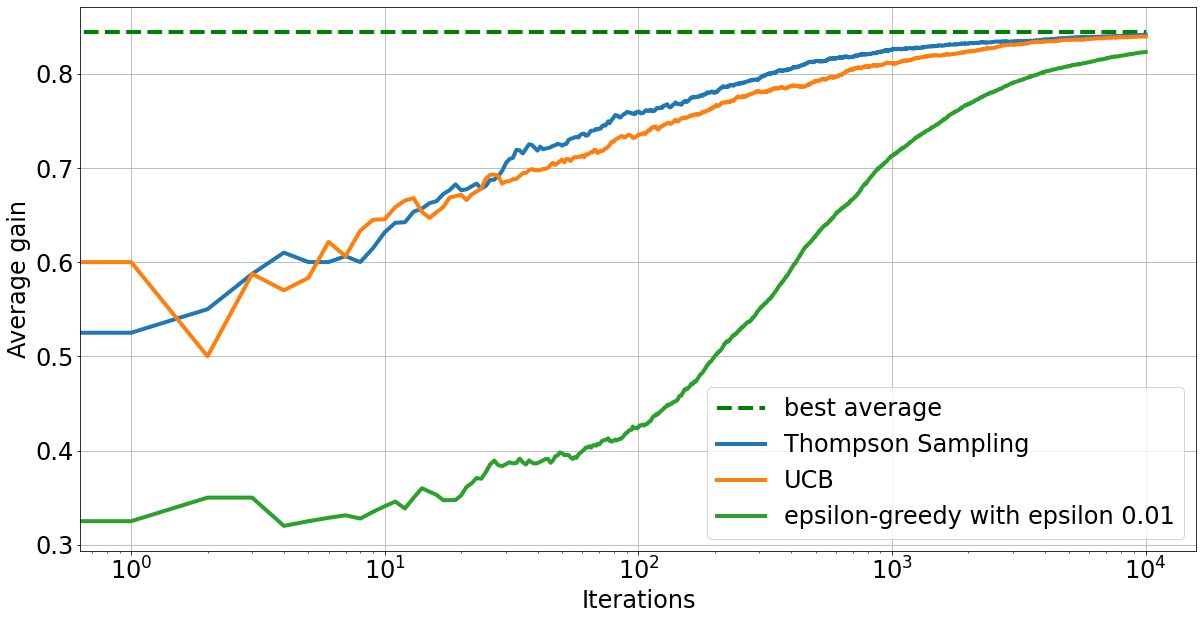

In [69]:
# On trace le gain moyen en fonction des itérations

r_max = np.max(bandits_pb._true_values)

plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(mean_cum_reward_thomson/ np.arange(1, n_draws+1), label='Thompson Sampling')
plt.semilogx(mean_cum_reward_Ucb / np.arange(1, n_draws+1), label='UCB')
plt.semilogx(mean_cum_reward_epsilon_greedy / np.arange(1, n_draws+1), label='epsilon-greedy with epsilon {}'.format(epsilon_greedy_algo.epsilon))
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

Nous observons qu'en moyenne les deux strategies Thompson Sampling et UCB ont pu converge vers le meilleur gain tandis que la stratage epsilon-greedy a échoué

Comparons maintenant le regret des resulats moyens des trois algorithmes

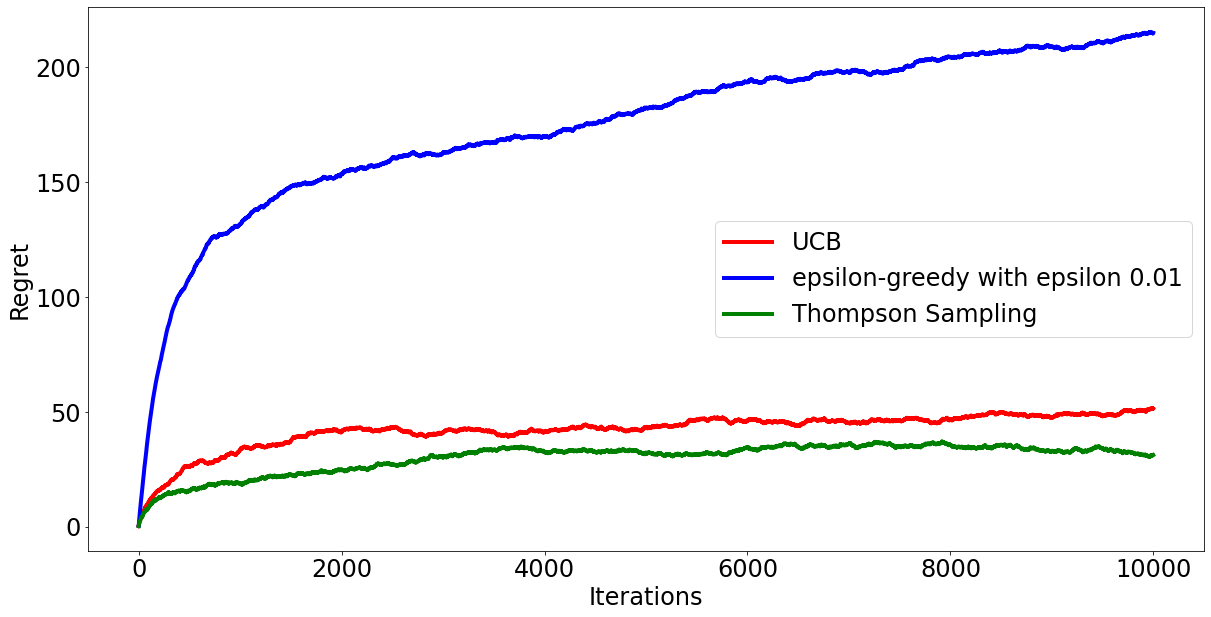

In [70]:
regret_thomson = np.arange(1, n_draws+1) * r_max - mean_cum_reward_thomson
regret_epsilon_greedy = np.arange(1, n_draws+1) * r_max - mean_cum_reward_epsilon_greedy
regret_Ucb = np.arange(1, n_draws+1) * r_max - mean_cum_reward_Ucb

# Le regret sur une simu
plt.plot(regret_Ucb,'r', label='UCB')
plt.plot(regret_epsilon_greedy,'b', label='epsilon-greedy with epsilon {}'.format(epsilon_greedy_algo.epsilon))
plt.plot(regret_thomson,'g', label='Thompson Sampling')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()



Nous constations au final que l'algorithme $\epsilon-greedy$ explose en termes de regret après quelques dizaines milliers d'itérations.

Les algorithmes TS et UCB performe relativement bien par rapport à l'algo $\epsilon-greedy$.

L'algorithme TS dépasse légèrement l'algo UCB.